In [10]:
import pandas as pd
import polars as pl
import os
import glob
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For unique labels in confusion matrix

In [11]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    """
    Plots a confusion matrix using seaborn.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cmn, annot=False, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

Found 2 CSV files to analyze in d:\Github\part-of-speech-tagging\data\runs:

--- Analyzing: unigram_dev.csv ---
Accuracy: 0.9136
Weighted Precision: 0.8305
Weighted Recall: 0.7897
Weighted F1-Score: 0.7954



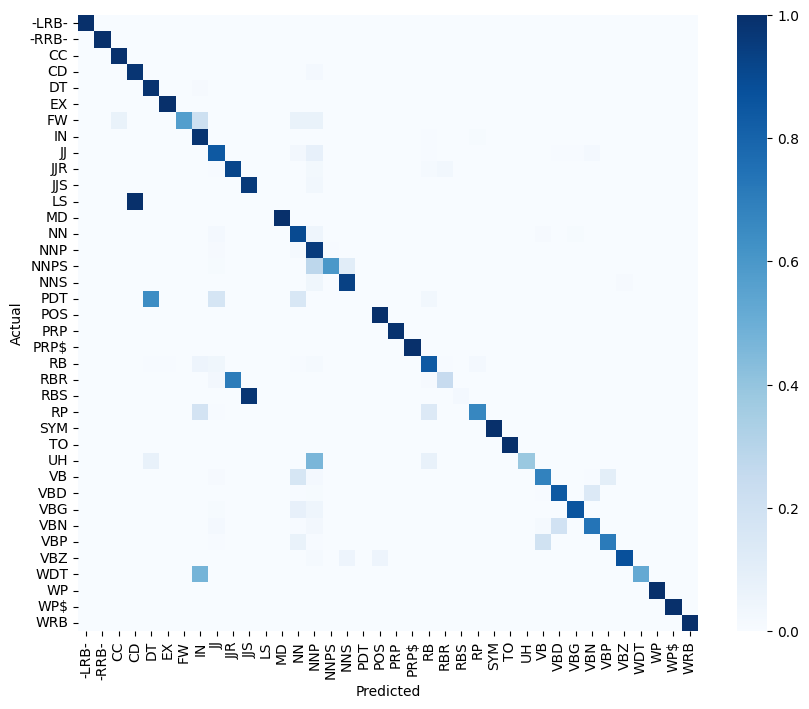



--- Analyzing: unigram_test.csv ---
Accuracy: 0.9156
Weighted Precision: 0.8165
Weighted Recall: 0.7748
Weighted F1-Score: 0.7779



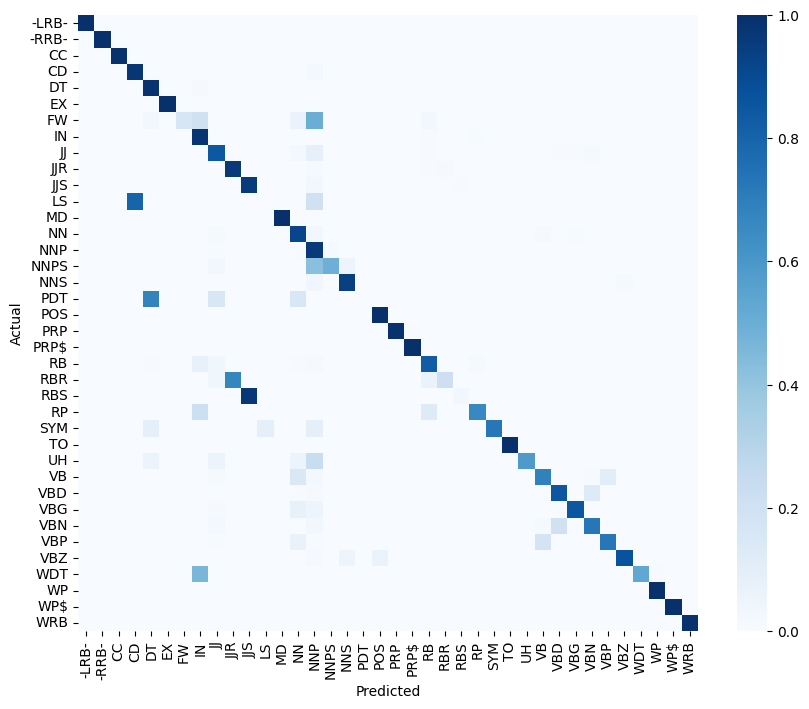

In [12]:
# Adjust the path if your notebook is not in the 'analysis' directory
# or if 'data/runs/' is located elsewhere relative to the notebook.
runs_directory = '../data/runs/' # Assuming the notebook is in the 'analysis' folder
csv_files = glob.glob(os.path.join(runs_directory, '*.csv'))

if not csv_files:
    print(f"No CSV files found in {os.path.abspath(runs_directory)}")
else:
    print(f"Found {len(csv_files)} CSV files to analyze in {os.path.abspath(runs_directory)}:\n")
    for file_path in csv_files:
        print(f"--- Analyzing: {os.path.basename(file_path)} ---")
        try:
            # Try reading with pandas, assuming 'real' and 'pred' columns
            df = pd.read_csv(file_path)

            chars_to_remove = [',', '``', "''", '``','.',';','#','%',"'",'"',"$",":"] # Added ` to the set of characters
            df = df[~df['word'].isin(chars_to_remove)]
            df = df[~df['real'].isin(chars_to_remove)]
            if 'real' not in df.columns or 'pred' not in df.columns:
                print(f"Skipping {os.path.basename(file_path)}: Missing 'real' or 'pred' columns.")
                continue

            # Ensure no NaN values in 'real' or 'pred' columns, fill with a placeholder if necessary
            # or drop them. For metrics, it's often better to ensure they are strings.
            df['real'] = df['real'].astype(str).fillna('UNK_FILL')
            df['pred'] = df['pred'].astype(str).fillna('UNK_FILL')

            y_true = df['real']
            y_pred = df['pred']

            # Get all unique labels from both true and predicted for consistent matrix dimensions
            labels = sorted(list(np.union1d(y_true.unique(), y_pred.unique())))

            # Calculate Metrics
            accuracy = accuracy_score(y_true, y_pred)
            # average='weighted' handles label imbalance. Use 'macro' for unweighted average.
            precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', labels=labels, zero_division=0)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"Weighted Precision: {precision:.4f}")
            print(f"Weighted Recall: {recall:.4f}")
            print(f"Weighted F1-Score: {f1:.4f}\n")

            # Display Confusion Matrix
            plot_confusion_matrix(y_true, y_pred, labels=labels, title=f'Confusion Matrix for {os.path.basename(file_path)}')
            print("\n" + "="*50 + "\n")

        except Exception as e:
            print(f"Error processing {os.path.basename(file_path)}: {e}")
            print("\n" + "="*50 + "\n")